### Project 5: Interpretability

__Case Description__

The focus of this project is to design, implement, test, compare, and document a selection of model interpretability methods in order to reason about why our models make the decisions they do with applications to, e.g. regression or classification problems. The algorithms must be optimized with regard to applicable properties of explanation methods (see IML Sec. 2.5), i.e. results must be shown such that end-users readily can see an explanation for a prediction. To quantify the quality of the methods, comparative evaluations should be carried out via objective metrics and the algorithms should be assessed against state of the art.

__Inspiration__

- https://towardsdatascience.com/lime-vs-shap-which-is-better-for-explaining-machine-learning-models-d68d8290bb16 (Lime)
- https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html (SHAP)
- https://www.kaggle.com/code/cheedcheed/what-features-predict-the-winner-lightgbm-shap (Implementation)
- https://www.kaggle.com/code/ashutoshsinha/cs-go-round-winner-classification           (Implementation)

In [9]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import shap
import lime
from lime import lime_tabular
import warnings
import logging
logging.getLogger('shap').setLevel(logging.WARNING)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [10]:
#Load dataset 
df = pd.read_csv('csgo_round_snapshots.csv')
display(df.head(10))
display(df.describe())
print(df.shape)

#divide into x and y 
y = df['round_winner']                  #target values
x = df.drop(['round_winner'], axis=1)   #all other columns that target values

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
5,114.97,1.0,0.0,de_dust2,False,500.0,500.0,500.0,0.0,1750.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CT
6,94.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
7,74.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
8,54.97,1.0,0.0,de_dust2,False,249.0,89.0,269.0,0.0,2300.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
9,174.97,2.0,0.0,de_dust2,False,500.0,500.0,196.0,0.0,19800.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000
mean,97.886922,6.709239,6.780435,412.106568,402.714500,314.142121,298.444670,9789.023773,11241.036680,2.053901,...,1.853157,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750
std,54.465238,4.790362,4.823543,132.293290,139.919033,171.029736,174.576545,11215.042286,12162.806759,1.841470,...,1.772791,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.920000,3.000000,3.000000,350.000000,322.000000,194.000000,174.000000,1300.000000,1550.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5500.000000,7150.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,166.917500,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14600.000000,18000.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
max,175.000000,32.000000,33.000000,500.000000,600.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,...,7.000000,7.000000,6.000000,9.000000,5.000000,3.000000,3.000000,5.000000,3.000000,2.000000


(122410, 97)


### Exploratory Data Analysis (EDA) 


T     62406
CT    60004
Name: round_winner, dtype: int64

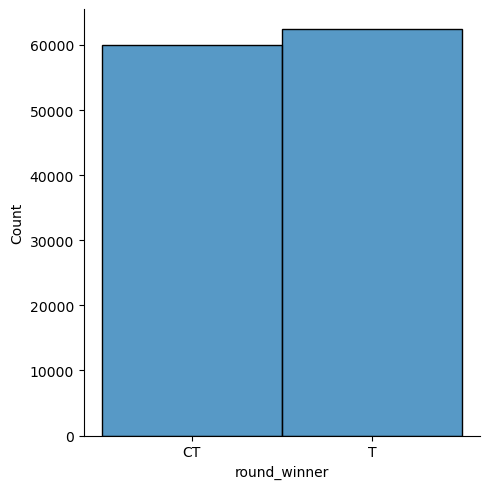

In [11]:
#number of round winners
sns.displot(df['round_winner'], kde=False)
df['round_winner'].value_counts()

map,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo
round_winner,,,,,,,,
CT,103,10158,10810,9144,10214,7026,7310,5239
T,42,11986,13001,9432,8811,7055,6181,5898


<AxesSubplot:xlabel='round_winner', ylabel='count'>

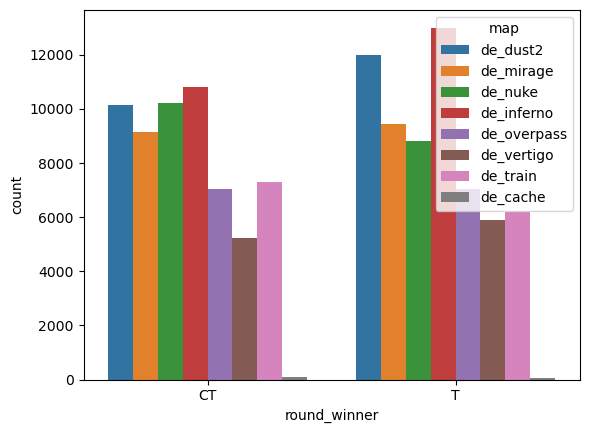

In [12]:
#comparing winners according to map 
display(pd.crosstab(df['round_winner'], df['map']))
sns.countplot(x='round_winner', hue='map', data=df)


### Data Preprocessing

In [13]:
"""
Check Columns (Null and non-numeric values)
"""
#null columns 
print("Columns:\n", df.isnull().any())
print("\nNumber of NULL columns:", df.isnull().sum().sum(), "\n")

#non-numeric values
display(df.drop(df.select_dtypes(np.number), axis = 1))


Columns:
 time_left                    False
ct_score                     False
t_score                      False
map                          False
bomb_planted                 False
                             ...  
ct_grenade_molotovgrenade    False
t_grenade_molotovgrenade     False
ct_grenade_decoygrenade      False
t_grenade_decoygrenade       False
round_winner                 False
Length: 97, dtype: bool

Number of NULL columns: 0 



,map,bomb_planted,round_winner
0,de_dust2,False,CT
1,de_dust2,False,CT
2,de_dust2,False,CT
3,de_dust2,False,CT
4,de_dust2,False,CT
...,...,...,...
122405,de_train,True,T
122406,de_train,False,T
122407,de_train,False,T
122408,de_train,False,T


In [14]:
"""
Encode features
"""
#one hot encode map and bomb_planted 
oneHotEncoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

x_encoded = pd.DataFrame(oneHotEncoder.fit_transform(x[['map', 'bomb_planted']]))
x_encoded.columns = oneHotEncoder.get_feature_names_out(['map', 'bomb_planted'])
x_encoded.index = x.index

#insert encoded variables back into dataset
numerical_x = x.drop(['map', 'bomb_planted'], axis=1)
x = pd.concat([numerical_x, x_encoded], axis=1)

#encode target values as they have value true/false
labelEncoder = LabelEncoder()
labelEncoder.fit(y)
y = labelEncoder.transform(y)


#check if variables are encoded
map_mapping = {index : label for index, label in enumerate(oneHotEncoder.categories_)}
round_mapping = {index : label for index, label in enumerate(labelEncoder.classes_)}
print("Maps encoding: ", map_mapping, "\nRound Winner encoding: ", round_mapping)

Maps encoding:  {0: array(['de_cache', 'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke',
       'de_overpass', 'de_train', 'de_vertigo'], dtype=object), 1: array([False,  True])} 
Round Winner encoding:  {0: 'CT', 1: 'T'}


In [15]:
"""
Prepare for training and testing
"""
#normalize data
scaler = RobustScaler()
scaled_x = scaler.fit_transform(x)
scaled_x = pd.DataFrame(scaled_x, columns=x.columns)

# Splitting the dataset into the training set and test set
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.2, random_state=42)


#lightgbm model
#lgb_train = lgb.Dataset(x_train, label=y_train)
#lgb_test = lgb.Dataset(x_test, label=y_test)

### Training and Testing

In [16]:
"""
Logistic Regression
"""
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=22)
#model = RandomForestClassifier(random_state=22)
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print('Accuracy on train:  ' + str(accuracy_score(y_train, y_train_pred)))
print('Recall on train:    ' + str(recall_score(y_train, y_train_pred)))
print('Precision on train: ' + str(precision_score(y_train, y_train_pred)))

print('Accuracy on test:   ' + str(accuracy_score(y_test, y_test_pred)))
print('Recall on test:     ' + str(recall_score(y_test, y_test_pred)))
print('Precision on test:  ' + str(precision_score(y_test, y_test_pred)))


Accuracy on train:  0.7501531737603137
Recall on train:    0.7435907707098222
Precision on train: 0.7609190219507697
Accuracy on test:   0.750469732864962
Recall on test:     0.7420259656996313
Precision on test:  0.7621203391225615


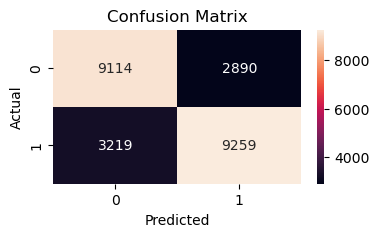

In [17]:
"""
Confusion matrix
"""
y_pred = np.where(y_test_pred > 0.5, 1, 0)

#create confusion matrix
cm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, fmt='g')
plt.title("Confusion Matrix")
plt.show()

### Interpretability Methods

In [18]:
"""
SHAP
"""
#initialize 
shap.initjs()

#create explainer and get shap values
explainer = shap.Explainer(model, x_train)
shap_values = explainer.shap_values(x_test)



In [19]:
#Get the coefficients of the features
coefs = model.coef_

#Print the coefficients of the features
for i, feature in enumerate(x.columns):
    print("{}: {}".format(feature, coefs[0][i]))



time_left: 0.1700256999332512
ct_score: -0.030400946364743213
t_score: 0.028352444515332743
ct_health: -0.7246039466255526
t_health: 0.6340614902816435
ct_armor: -0.837368330775746
t_armor: 0.8178421285273699
ct_money: -0.20265302562660706
t_money: 0.18663396266225504
ct_helmets: -0.009874571896132934
t_helmets: 0.7379766764279003
ct_defuse_kits: -0.035176941093425416
ct_players_alive: -0.32234462163506244
t_players_alive: 0.43481627871485934
ct_weapon_ak47: -0.353121464614147
t_weapon_ak47: 0.810791019145765
ct_weapon_aug: -0.45405791056410855
t_weapon_aug: 0.33265568268031936
ct_weapon_awp: -0.4776021477217105
t_weapon_awp: 0.4503087775295477
ct_weapon_bizon: 0.0
t_weapon_bizon: 0.40569133021568576
ct_weapon_cz75auto: -0.04280324429611697
t_weapon_cz75auto: 0.12106131958683096
ct_weapon_elite: -0.17452070217633567
t_weapon_elite: 0.29449199785320723
ct_weapon_famas: -0.39114170131038767
t_weapon_famas: 0.6966409563150456
ct_weapon_g3sg1: 0.0
t_weapon_g3sg1: 0.43085429408895737
ct_wea

Index(['ct_weapon_awp', 'ct_players_alive', 't_weapon_sg553', 't_armor',
       't_health', 'ct_armor', 't_players_alive', 'ct_weapon_m4a4',
       't_weapon_ak47', 'ct_health'],
      dtype='object')


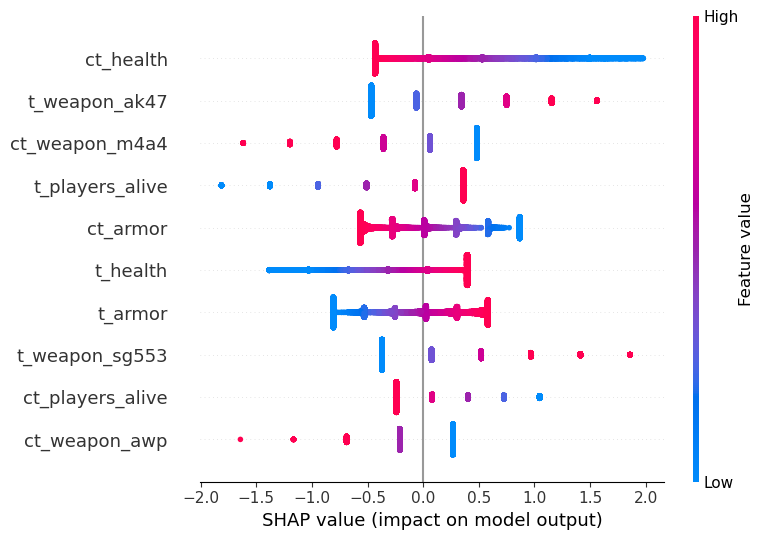

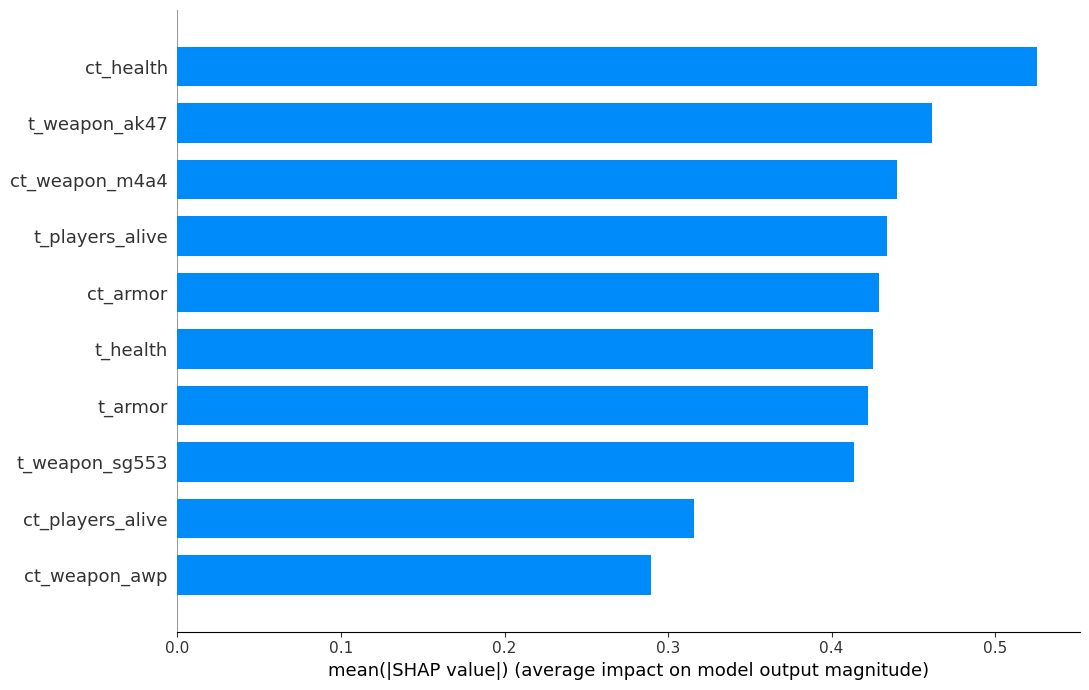

In [20]:
"""
Summary plot
"""
k = 10
feature_names = x.columns

#getting the top 10 features 
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(mean_abs_shap_values)[-k:]
top_features = x.columns[top_features_idx]

print(top_features)

#beeswarm plot
shap.summary_plot(shap_values, x_test, feature_names=feature_names, max_display=k)

#bar plot
shap.summary_plot(shap_values, x_test, plot_type="bar", feature_names=feature_names, max_display=10, plot_size = (11,7))


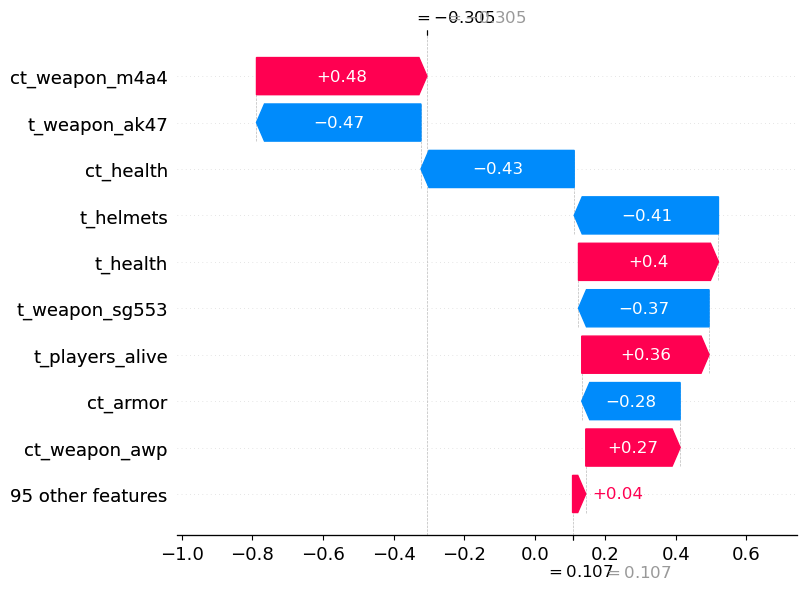

In [21]:
"""
Waterfall plot
"""
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], feature_names=feature_names, max_display=10)

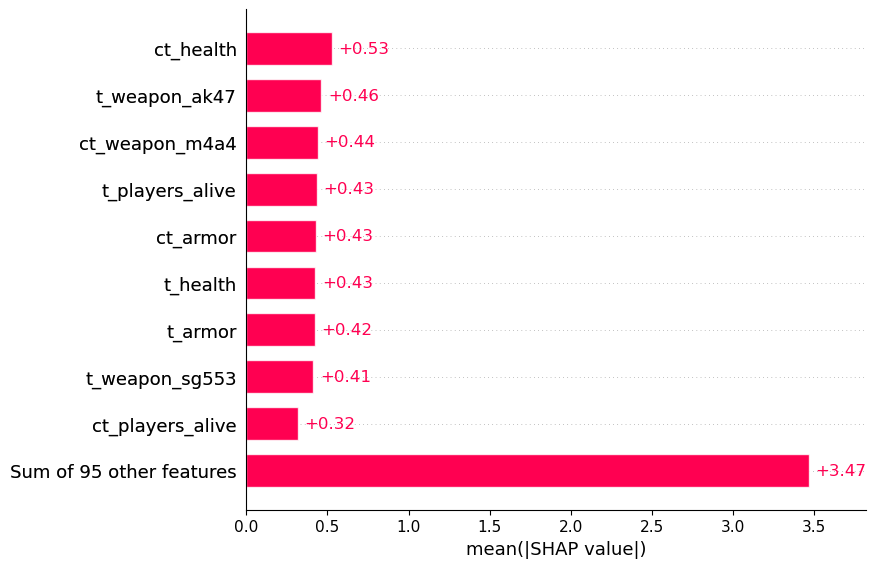

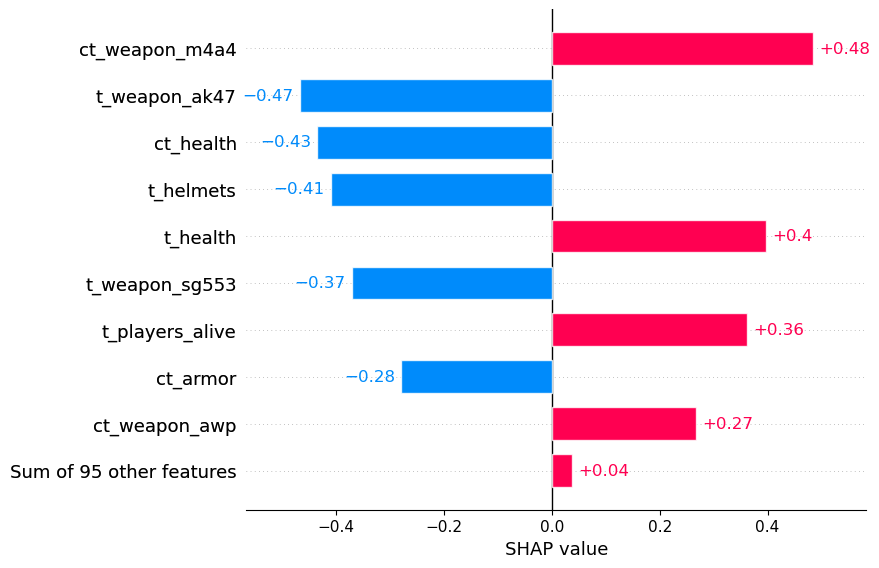

In [22]:
"""
Bar plot
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html
"""
sample_ind = 25

#global bar plot
shap.plots.bar(explainer(x_test), max_display=10)

#local bar plot
shap.plots.bar(explainer(x_test)[0], max_display=10)


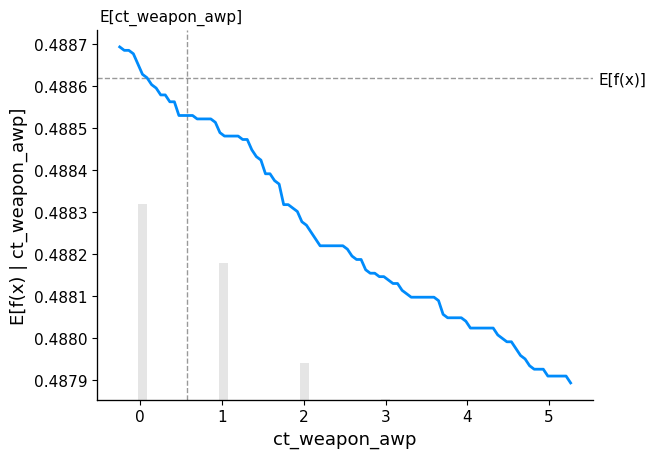

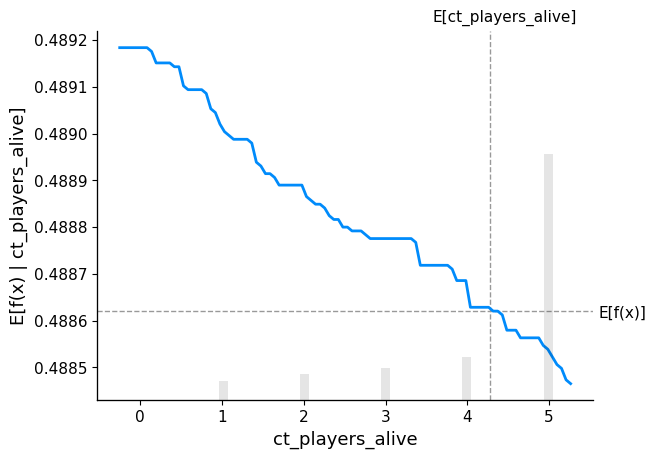

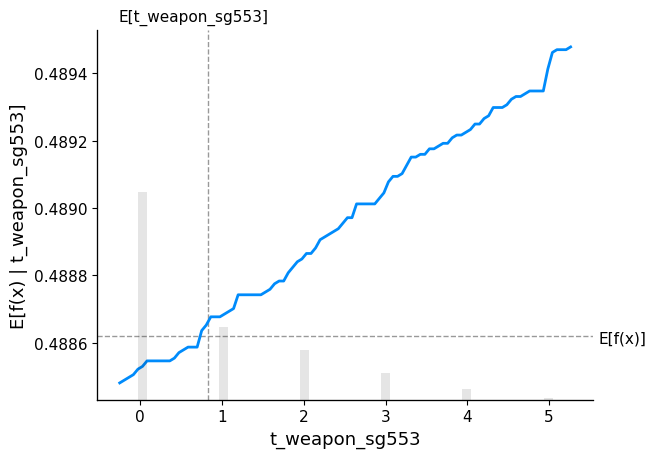

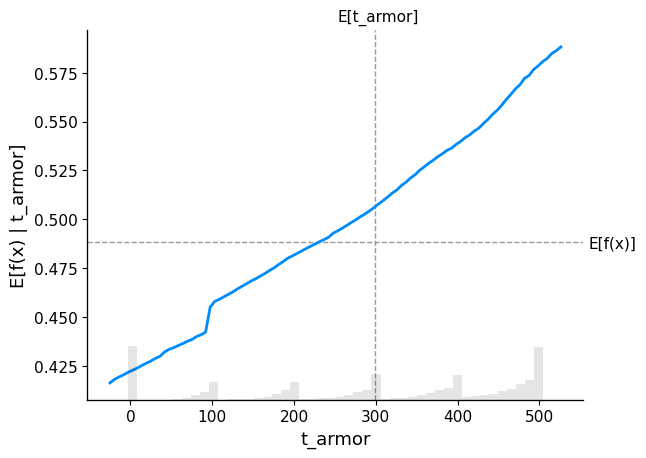

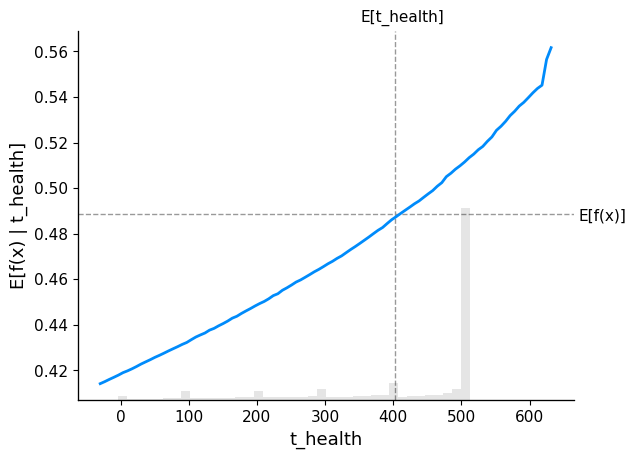

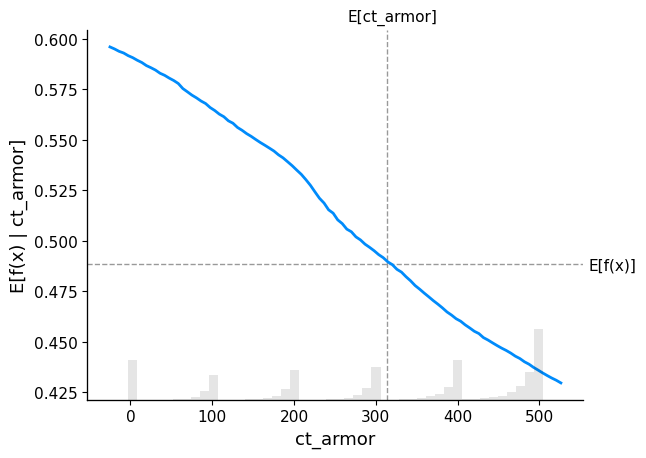

In [23]:
"""
Partial dependence plot 
"""
plot_num = 6 #number of plots

for f in top_features[:plot_num]:
    shap.partial_dependence_plot(
        f, model.predict, x, ice=False,
        model_expected_value=True, feature_expected_value=True
    )


[Text(0.5, 0.03, 'ct_weapon_awp'),
 Text(1.5, 0.03, 'ct_players_alive'),
 Text(2.5, 0.03, 't_weapon_sg553'),
 Text(3.5, 0.03, 't_armor'),
 Text(4.5, 0.03, 't_health'),
 Text(5.5, 0.03, 'ct_armor'),
 Text(6.5, 0.03, 't_players_alive'),
 Text(7.5, 0.03, 'ct_weapon_m4a4'),
 Text(8.5, 0.03, 't_weapon_ak47'),
 Text(9.5, 0.03, 'ct_health')]

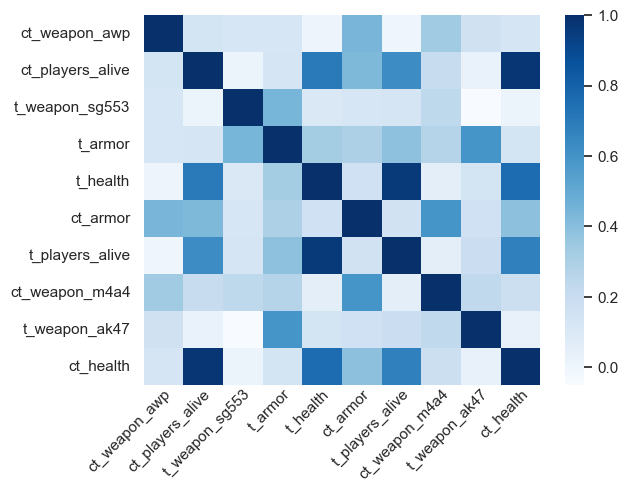

In [38]:
"""
Correlation matrix
"""
# Create a heatmap of corralation between the top 20 features with perason method
corr = x[top_features[:k]].corr(method='pearson')
# Plot the heatmap as a square
sns.set()
ax = sns.heatmap(corr, annot=False, fmt='.2f', cmap='Blues', cbar=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', rotation_mode='anchor', y=0.03)

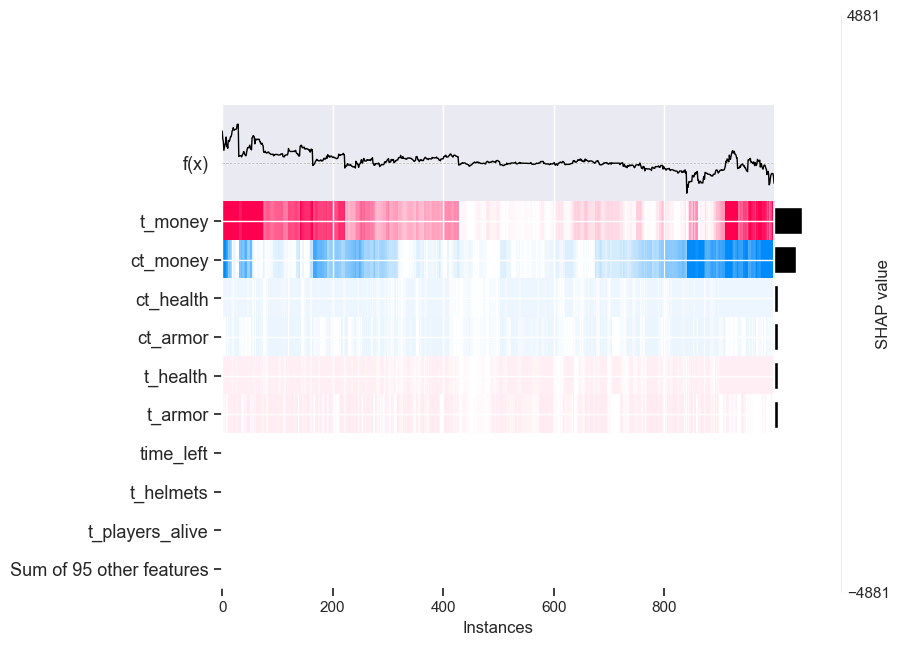

In [39]:
"""
Heatmap
"""
shap_values = explainer(x[:1000])
shap.plots.heatmap(shap_values, max_display=k)



In [ ]:
"""
Force plot 
"""
instance_idx = 25
instance = x.iloc[[instance_idx]]
shap_values = explainer.shap_values(instance)

shap.force_plot(explainer.expected_value, shap_values, instance)



Permutation explainer: 1001it [00:55, 15.94it/s]                          


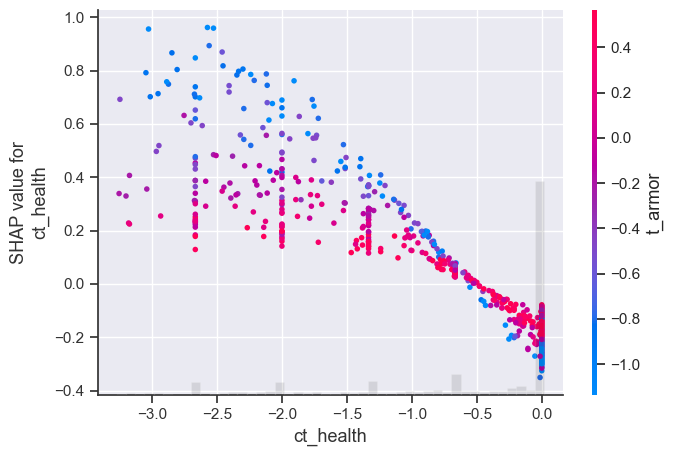

In [40]:
"""
Scatter plot 
"""
explainer = shap.Explainer(lambda x: model.predict_log_proba(x)[:,1], x_train)
shap_values = explainer(x_train[:1000])
shap.plots.scatter(shap_values[:,"ct_health"], color=shap_values)


In [41]:
"""
LIME
"""
#create test
i = 8
test_1 = x_test.iloc[i]

#create lime explainer
explainer = lime_tabular.LimeTabularExplainer(training_data= np.array(x_train),                                               
                                                   mode='classification',
                                                   class_names=['CT', 'T'],                                                 
                                                   feature_names=feature_names)

#define plot 
exp = explainer.explain_instance(
    data_row = test_1,
    predict_fn = model.predict_proba, 
    num_features=k)

exp.show_in_notebook(show_table=True)
#exp.as_pyplot_figure()
#plt.show()

X does not have valid feature names, but LogisticRegression was fitted with feature names
